Plot Tide Forecasts
===================

Plots the daily tidal displacements for a given location

OTIS format tidal solutions provided by Ohio State University and ESR  
- http://volkov.oce.orst.edu/tides/region.html  
- https://www.esr.org/research/polar-tide-models/list-of-polar-tide-models/
- ftp://ftp.esr.org/pub/datasets/tmd/  

Global Tide Model (GOT) solutions provided by Richard Ray at GSFC  

Finite Element Solution (FES) provided by AVISO  
- https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes.html

#### Python Dependencies
 - [numpy: Scientific Computing Tools For Python](https://www.numpy.org)  
 - [scipy: Scientific Tools for Python](https://www.scipy.org/)  
 - [pyproj: Python interface to PROJ library](https://pypi.org/project/pyproj/)  
 - [netCDF4: Python interface to the netCDF C library](https://unidata.github.io/netcdf4-python/)  
 - [matplotlib: Python 2D plotting library](https://matplotlib.org/)  
 - [ipyleaflet: Jupyter / Leaflet bridge enabling interactive maps](https://github.com/jupyter-widgets/ipyleaflet)  

#### Program Dependencies

- `calc_astrol_longitudes.py`: computes the basic astronomical mean longitudes  
- `calc_delta_time.py`: calculates difference between universal and dynamic time  
- `convert_ll_xy.py`: convert lat/lon points to and from projected coordinates  
- `load_constituent.py`: loads parameters for a given tidal constituent  
- `load_nodal_corrections.py`: load the nodal corrections for tidal constituents  
- `infer_minor_corrections.py`: return corrections for minor constituents  
- `model.py`: retrieves tide model parameters for named tide models  
- `read_tide_model.py`: extract tidal harmonic constants from OTIS tide models  
- `read_netcdf_model.py`: extract tidal harmonic constants from netcdf models  
- `read_GOT_model.py`: extract tidal harmonic constants from GSFC GOT models  
- `read_FES_model.py`: extract tidal harmonic constants from FES tide models  
- `predict_tidal_ts.py`: predict tidal time series at a location using harmonic constants  

This notebook uses Jupyter widgets to set parameters for calculating the tidal maps.  

#### Load modules

In [1]:
from __future__ import print_function

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import IPython.display

import pyTMD.time
import pyTMD.model
import pyTMD.tools
from pyTMD.calc_delta_time import calc_delta_time
from pyTMD.infer_minor_corrections import infer_minor_corrections
from pyTMD.predict_tidal_ts import predict_tidal_ts
from pyTMD.read_tide_model import extract_tidal_constants
from pyTMD.read_netcdf_model import extract_netcdf_constants
from pyTMD.read_GOT_model import extract_GOT_constants
from pyTMD.read_FES_model import extract_FES_constants
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# available model list
model_list = sorted(pyTMD.model.ocean_elevation())
# # display widgets for setting directory and model
# TMDwidgets = pyTMD.tools.widgets()
# TMDwidgets.model.options = model_list
# TMDwidgets.model.value = 'GOT4.10'
# widgets.VBox([
#     TMDwidgets.directory,
#     TMDwidgets.model,
#     TMDwidgets.atlas,
#     TMDwidgets.compress,
#     TMDwidgets.datepick
# ])

# Specify Parameters

In [80]:
# print(TMDwidgets.directory.value)
# print(TMDwidgets.model.value)
# print(TMDwidgets.atlas.value)
# print(TMDwidgets.compress.value)
# print(TMDwidgets.datepick.value)

model_dir = '/Users/dporter/data/Global/tidal_solutions/'
tidemodel = 'Gr1kmTM'
atlas = 'netcdf'
compressedfiles = False
datepick = datetime.date(2022, 12, 12) # datetime.date.today()



In [82]:
#-- default coordinates to use
# LAT,LON = (32.93301304,242.7294513)  # San Diego
# LAT,LON = (-77, 170)  # Antarctica

# LAT,LON = (64.1814, -53.6941)
# SITE_NAME = 'Nuuk'

LAT,LON = (74.5194, -57.9041)
SITE_NAME = 'Kullorsuaq'

# LAT,LON = (65.5, -37.6)
# SITE_NAME = 'Ammassalik'

# LAT,LON = (60.4, -46.0)
# SITE_NAME = 'Qaqortoq'

# Run Model

In [83]:
# get model parameters
model = pyTMD.model(model_dir,
    format=atlas,
    compressed=compressedfiles
   ).elevation(tidemodel)

# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = datepick
# calculate a weeks forecast every minute
ndays = 31
minutes = np.arange(ndays*1440)
tide_time = pyTMD.time.convert_calendar_dates(YMD.year, YMD.month,
    YMD.day, minute=minutes)
hours = minutes/60.0
# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

# leaflet location
# LAT,LON = np.copy(m.marker.location)
# # verify longitudes
# LON = m.wrap_longitudes(LON)
# read tidal constants and interpolate to leaflet points
if model.format in ('OTIS','ATLAS','ESR'):
    amp,ph,D,c = extract_tidal_constants(np.atleast_1d(LON),
        np.atleast_1d(LAT), model.grid_file, model.model_file,
        model.projection, type=model.type, method='spline',
        extrapolate=True, grid=model.format)
    DELTAT = np.zeros_like(tide_time)
elif (model.format == 'netcdf'):
    amp,ph,D,c = extract_netcdf_constants(np.atleast_1d(LON),
        np.atleast_1d(LAT), model.grid_file, model.model_file,
        type=model.type, method='spline', extrapolate=True,
        scale=model.scale, compressed=model.compressed)
    DELTAT = np.zeros_like(tide_time)
elif (model.format == 'GOT'):
    amp,ph,c = extract_GOT_constants(np.atleast_1d(LON),
        np.atleast_1d(LAT), model.model_file, method='spline',
        extrapolate=True, scale=model.scale,
        compressed=model.compressed)
    # interpolate delta times from calendar dates to tide time
    DELTAT = calc_delta_time(delta_file, tide_time)
elif (model.format == 'FES'):
    amp,ph = extract_FES_constants(np.atleast_1d(LON),
        np.atleast_1d(LAT), model.model_file, type=model.type,
        version=model.version, method='spline', extrapolate=True,
        scale=model.scale, compressed=model.compressed)
    c = model.constituents
    # interpolate delta times from calendar dates to tide time
    DELTAT = calc_delta_time(delta_file, tide_time)

# calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
# calculate constituent oscillation
hc = amp*np.exp(cph)

# convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
# predict tidal elevations at time 1 and infer minor corrections
TIDE = predict_tidal_ts(tide_time, hc, c,
    deltat=DELTAT, corrections=model.format)
MINOR = infer_minor_corrections(tide_time, hc, c,
    deltat=DELTAT, corrections=model.format)
TIDE.data[:] += MINOR.data[:]
# convert to centimeters
TIDE.data[:] *= 100.0

# differentiate to calculate high and low tides
diff = np.zeros_like(tide_time, dtype=np.float64)
# forward differentiation for starting point
diff[0] = TIDE.data[1] - TIDE.data[0]
# backward differentiation for end point
diff[-1] = TIDE.data[-1] - TIDE.data[-2]
# centered differentiation for all others
diff[1:-1] = (TIDE.data[2:] - TIDE.data[0:-2])/2.0
# indices of high and low tides
htindex, = np.nonzero((np.sign(diff[0:-1]) >= 0) & (np.sign(diff[1:]) < 0))
ltindex, = np.nonzero((np.sign(diff[0:-1]) <= 0) & (np.sign(diff[1:]) > 0))

# Plot time series

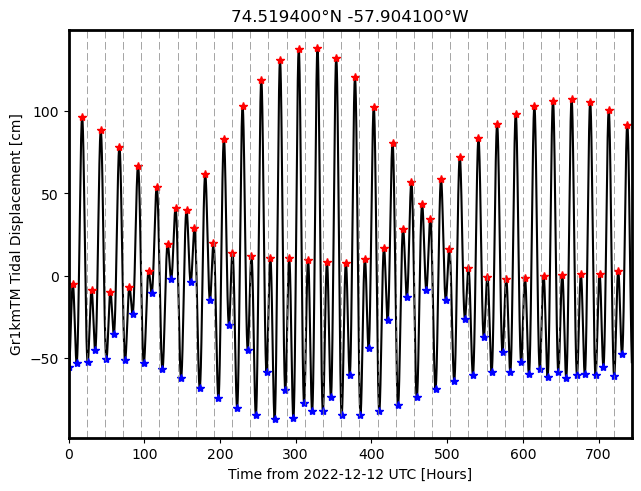

In [84]:
# create plot with tidal displacements, high and low tides and dates
fig,ax1 = plt.subplots(num=1)
xmax = np.ceil(hours[-1]).astype('i')
ax1.plot(hours, TIDE.data, 'k')
ax1.plot(hours[htindex], TIDE.data[htindex], 'r*')
ax1.plot(hours[ltindex], TIDE.data[ltindex], 'b*')
for h in range(24,xmax,24):
    ax1.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))
ax1.set_xlim(0,xmax)
ax1.set_ylabel('{0} Tidal Displacement [cm]'.format(model.name))
args = (YMD.year,YMD.month,YMD.day)
ax1.set_xlabel('Time from {0:4d}-{1:02d}-{2:02d} UTC [Hours]'.format(*args))
ax1.set_title(u'{0:0.6f}\u00b0N {1:0.6f}\u00b0W'.format(LAT,LON))
fig.subplots_adjust(left=0.10,right=0.98,bottom=0.10,top=0.95)
# plt.savefig(f'{SITE_NAME}_H_{YMD}_week.png')
# plt.show()

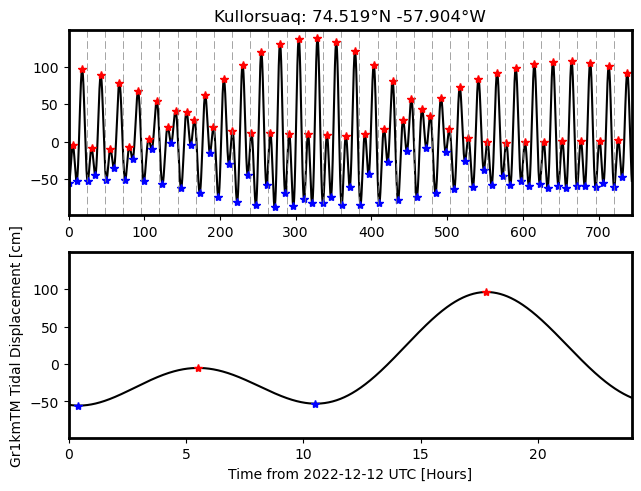

In [85]:
# create plot with tidal displacements, high and low tides and dates
fig, (ax1, ax2) = plt.subplots(2, sharey=True)
xmax = np.ceil(hours[-1]).astype('i')
ax1.set_title(SITE_NAME + u': {0:0.3f}\u00b0N {1:0.3f}\u00b0W'.format(LAT,LON))
ax1.plot(hours, TIDE.data, 'k')
ax1.plot(hours[htindex], TIDE.data[htindex], 'r*')
ax1.plot(hours[ltindex], TIDE.data[ltindex], 'b*')
for h in range(24,xmax,24):
    ax1.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))
ax1.set_xlim(0,xmax)

ax2.plot(hours, TIDE.data, 'k')
ax2.plot(hours[htindex], TIDE.data[htindex], 'r*')
ax2.plot(hours[ltindex], TIDE.data[ltindex], 'b*')
for h in range(24,xmax,24):
    ax2.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))
ax2.set_xlim(0,1*24)


args = (YMD.year,YMD.month,YMD.day)
ax2.set_ylabel('{0} Tidal Displacement [cm]'.format(model.name))
ax2.set_xlabel('Time from {0:4d}-{1:02d}-{2:02d} UTC [Hours]'.format(*args))
fig.subplots_adjust(left=0.10,right=0.98,bottom=0.10,top=0.95)
# plt.savefig(f'{SITE_NAME}_H_{YMD}_week.png')


# Convert to pandas dataframe

### create datetime object

In [86]:
import pandas as pd

dt = pd.date_range(start=YMD, periods=ndays*1440, freq='60S', tz='UTC')
print(dt[0:4])

DatetimeIndex(['2022-12-12 00:00:00+00:00', '2022-12-12 00:01:00+00:00',
               '2022-12-12 00:02:00+00:00', '2022-12-12 00:03:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='60S')


### create `dataframe` with new index

In [87]:
import pandas as pd

columns = ['minutes', 'SSH']
values = np.array([minutes, TIDE.data])
df = []
df = pd.DataFrame(data=values.T, columns=columns, index=dt)
df = df.apply(pd.to_numeric, errors='ignore')
df.head()

,minutes,SSH
2022-12-12 00:00:00+00:00,0.0,-54.401903
2022-12-12 00:01:00+00:00,1.0,-54.487105
2022-12-12 00:02:00+00:00,2.0,-54.568857
2022-12-12 00:03:00+00:00,3.0,-54.647164
2022-12-12 00:04:00+00:00,4.0,-54.722034


### localize datetime index for human use

In [88]:
tz_localize = 'America/Nuuk'
df.index = df.index.tz_convert(tz_localize)
df.index.name=tz_localize

## Plot `dataframe`

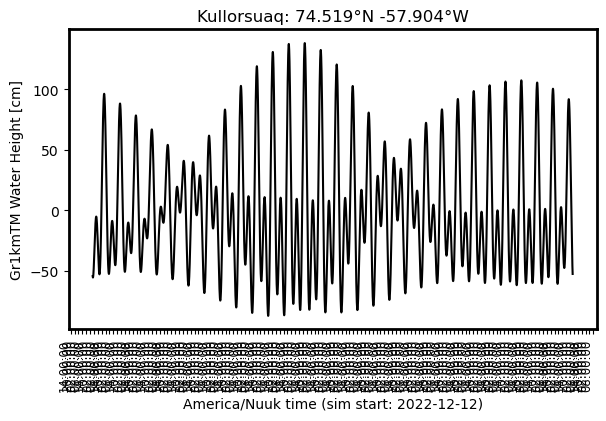

In [94]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

#-- create plot with tidal displacements, high and low tides and dates
fig,ax1 = plt.subplots(num=1, figsize=(6, 4))
ax1.plot(df.index,df.SSH,'k')
# ax1.plot(minutes[htindex]*24.0,TIDE.data[htindex],'r*')
# ax1.plot(minutes[ltindex]*24.0,TIDE.data[ltindex],'b*')
# for h in range(24,30*24,24):
#     ax1.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))

# ax1.set_xlim(pd.Timestamp('2022-12-2'), pd.Timestamp('2022-12-10'))
ax1.set_ylabel('{0} Water Height [cm]'.format(model.name))
args = (tz_localize, YMD.year,YMD.month,YMD.day)
ax1.set_xlabel('{0} time (sim start: {1:4d}-{2:02d}-{3:02d})'.format(*args))
ax1.set_title(SITE_NAME + u': {0:0.3f}\u00b0N {1:0.3f}\u00b0W'.format(LAT,LON))
fig.subplots_adjust(left=0.10,right=0.98,bottom=0.10,top=0.95)

## 1
hours = mdates.HourLocator(interval = 6)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax1.xaxis.set_major_locator(hours)
ax1.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
## 2
# dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
# plt.gca().xaxis.set_major_formatter(dtFmt) 
# # show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.xticks(rotation=90, fontweight='light',  fontsize='small',)


# plt.savefig(f'{SITE_NAME}_H_{YMD}_day_DATETIME_local.png')
plt.show()

## High and Low tides

In [90]:
df['min'] = df.SSH[(df.SSH.shift(1) > df.SSH) & (df.SSH.shift(-1) > df.SSH)]
df['max'] = df.SSH[(df.SSH.shift(1) < df.SSH) & (df.SSH.shift(-1) < df.SSH)]

<AxesSubplot: xlabel='America/Nuuk'>

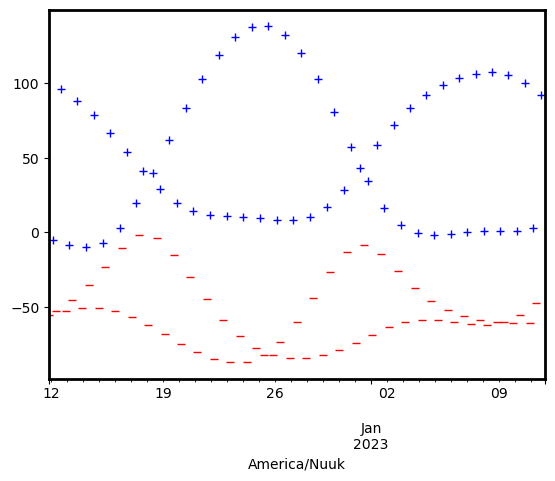

In [91]:
df['max'].plot(marker='+', color='blue')
df['min'].plot(marker='_', color='red')

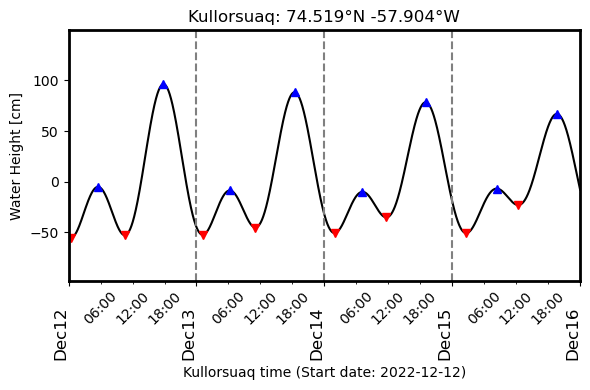

In [93]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

#-- create plot with tidal displacements, high and low tides and dates
fig,ax1 = plt.subplots(num=1, figsize=(6, 4))
ax1.plot(df.index,df.SSH,'k')

df['max'].plot(ax=ax1, marker='^', color='blue', ms=6)
df['min'].plot(ax=ax1, marker='v', color='red', ms=6)
# ax1.plot(minutes[htindex]*24.0,TIDE.data[htindex],'r*')
# ax1.plot(minutes[ltindex]*24.0,TIDE.data[ltindex],'b*')
# for h in range(24,30*24,24):
#     ax1.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))

##
ax1.axvline(YMD + pd.DateOffset(1), color='grey', linestyle='--')
ax1.axvline(YMD + pd.DateOffset(2), color='grey', linestyle='--')
ax1.axvline(YMD + pd.DateOffset(3), color='grey', linestyle='--')
# ax1.axvline(pd.to_datetime('2022-12-10'), color='k', linestyle='--')


ax1.set_xlim(YMD, YMD + pd.DateOffset(4))
ax1.set_ylabel('Water Height [cm]'.format(model.name))
args = (SITE_NAME, YMD.year,YMD.month,YMD.day) # 'tz_localize'
ax1.set_xlabel('{0} time (Start date: {1:4d}-{2:02d}-{3:02d})'.format(*args))
ax1.set_title(SITE_NAME + u': {0:0.3f}\u00b0N {1:0.3f}\u00b0W'.format(LAT,LON))
fig.subplots_adjust(left=0.10,right=0.98,bottom=0.10,top=0.95)

# ## 1
# hours = mdates.HourLocator(interval = 6)
# h_fmt = mdates.DateFormatter('%H:%M')

# ax1.xaxis.set_major_locator(hours)
# ax1.xaxis.set_major_formatter(h_fmt)
# # fig.autofmt_xdate(bottom=0.2, rotation=30, ha='center')
# ## 2
# # dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
# # plt.gca().xaxis.set_major_formatter(dtFmt) 
# # # show every 12th tick on x axes
# # plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
# Set major ticks with month names
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b%d'))
ax1.tick_params(axis="x", which="minor", rotation=45)
ax1.tick_params(axis="x", which="major", rotation=90, labelsize='large', pad=15)
# fig.autofmt_xdate(bottom=0.2, rotation=30, ha='center')

fig.tight_layout()
plt.savefig(f'{SITE_NAME}_H_{YMD}_4days_DATETIME_local_HighLow.png')
plt.show()

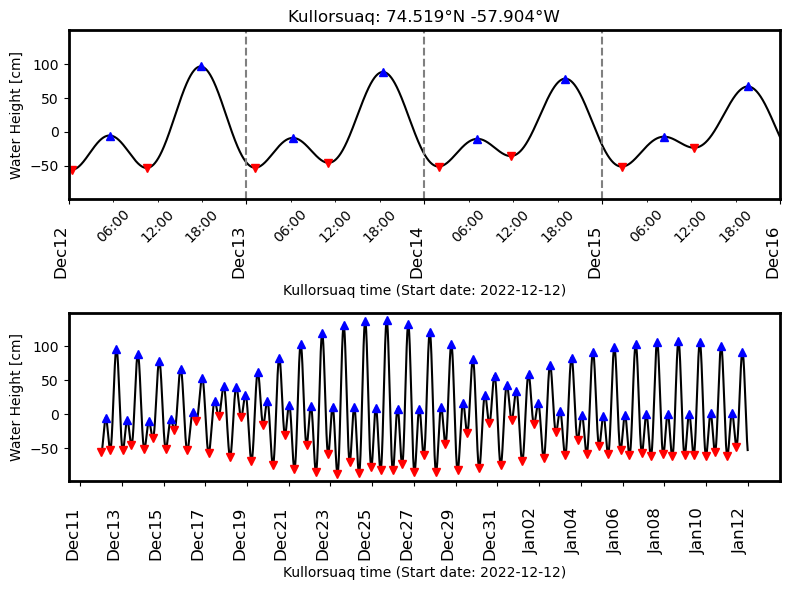

In [99]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

#-- create plot with tidal displacements, high and low tides and dates
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6), sharey=True)

ax1.plot(df.index,df.SSH,'k')
df['max'].plot(ax=ax1, marker='^', color='blue', ms=6)
df['min'].plot(ax=ax1, marker='v', color='red', ms=6)
# ax1.plot(minutes[htindex]*24.0,TIDE.data[htindex],'r*')
# ax1.plot(minutes[ltindex]*24.0,TIDE.data[ltindex],'b*')
# for h in range(24,30*24,24):
#     ax1.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))

##
ax1.axvline(YMD + pd.DateOffset(1), color='grey', linestyle='--')
ax1.axvline(YMD + pd.DateOffset(2), color='grey', linestyle='--')
ax1.axvline(YMD + pd.DateOffset(3), color='grey', linestyle='--')
# ax1.axvline(pd.to_datetime('2022-12-10'), color='k', linestyle='--')
#
ax1.set_xlim(YMD, YMD + pd.DateOffset(4))
ax1.set_ylabel('Water Height [cm]'.format(model.name))
args = (SITE_NAME, YMD.year,YMD.month,YMD.day) # 'tz_localize'
ax1.set_xlabel('{0} time (Start date: {1:4d}-{2:02d}-{3:02d})'.format(*args))
ax1.set_title(SITE_NAME + u': {0:0.3f}\u00b0N {1:0.3f}\u00b0W'.format(LAT,LON))
fig.subplots_adjust(left=0.10,right=0.98,bottom=0.10,top=0.95)
#
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
# Set major ticks with month names
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b%d'))
ax1.tick_params(axis="x", which="minor", rotation=45)
ax1.tick_params(axis="x", which="major", rotation=90, labelsize='large', pad=15)
# fig.autofmt_xdate(bottom=0.2, rotation=30, ha='center')

ax2.plot(df.index,df.SSH,'k')
df['max'].plot(ax=ax2, marker='^', color='blue', ms=6)
df['min'].plot(ax=ax2, marker='v', color='red', ms=6)
#
# ax2.set_xlim(YMD, YMD + pd.DateOffset(4))
ax2.set_ylabel('Water Height [cm]'.format(model.name))
args = (SITE_NAME, YMD.year,YMD.month,YMD.day) # 'tz_localize'
ax2.set_xlabel('{0} time (Start date: {1:4d}-{2:02d}-{3:02d})'.format(*args))
# ax1.set_title(SITE_NAME + u': {0:0.3f}\u00b0N {1:0.3f}\u00b0W'.format(LAT,LON))
fig.subplots_adjust(left=0.10,right=0.98,bottom=0.10,top=0.95)
#
# ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
# ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
# Set major ticks with month names
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b%d'))
ax2.tick_params(axis="x", which="minor", rotation=45)
ax2.tick_params(axis="x", which="major", rotation=90, labelsize='large', pad=15)
# fig.autofmt_xdate(bottom=0.2, rotation=30, ha='center')

fig.tight_layout()
plt.savefig(f'{SITE_NAME}_H_{YMD}_2panel_DATETIME_local_HighLow.png')
plt.show()

## Write High/Low tide `dataframe` to HTML table

In [100]:
# df[df['max'].notnull()]
# df[(df['max'].notnull()) | (df['min'].notnull())]

df_table = df[(df['max'].notnull()) | (df['min'].notnull())].rename(columns={'min': 'Low Tide','max':'High Tide'})

for col in df_table.columns.values:
    df_table[col] = df_table[col].replace(np.nan,0).astype('int64')

# html_table = (df_table
#               .drop(['minutes', 'SSH'], axis=1)
#               .replace(0, '', regex=True)
#               .to_html('tide_table_KHQ.html', formatters={'months': lambda x: x.strftime('%Y-%m')}, bold_rows=True)
#              )



In [101]:
def highlight(row):
    if row['High Tide'].astype('int') > 100:
        return ['background-color: red'] * len(row)
    else:
        return [''] * len(row)
    
def make_pretty(styler):
#     styler.apply(highlight, axis=1)
    styler.set_caption("Kullorsuaq Tide Chart (cm)")
    styler.format_index(lambda s: s.strftime("%Y-%m-%d, %H:%M"))
    styler.set_properties(**{'font-size': '12pt', 'font-family': 'Times'})
    return styler

html_table = (df_table
              .drop(['minutes', 'SSH'], axis=1)
              .replace(0, '', regex=True)
              .style.pipe(make_pretty)
              .to_html('tide_table_KHQ.html')
             )



# Write out to CSV

In [102]:
df.to_csv(f'./{SITE_NAME}_H_{YMD}_{model.name}.csv')  # , na_rep=" ")